In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as scipy
from scipy.spatial import KDTree, distance
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
import json
# graph representation
import networkx as nx
# Pulser imports
import pulser as pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import SimConfig, QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice
from pulser.waveforms import InterpolatedWaveform, RampWaveform, ConstantWaveform

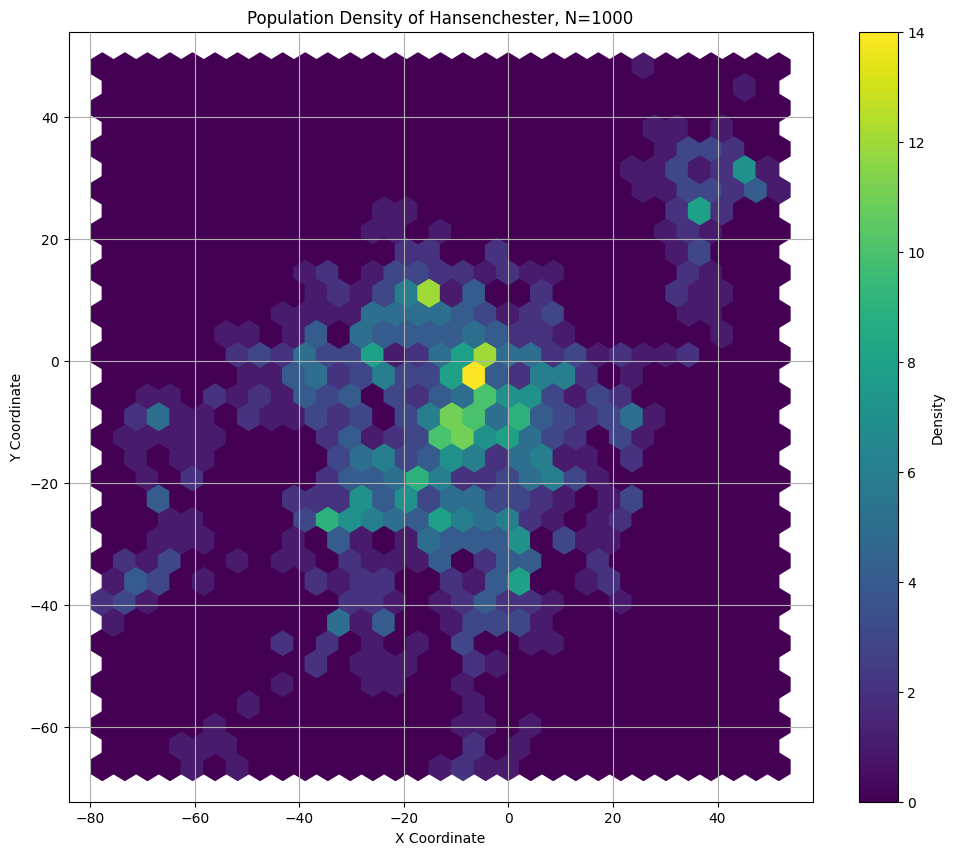

In [51]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[2]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.figure(figsize=(12, 10))
plt.hexbin(x, y, gridsize=30, cmap='viridis')
#plt.hist2d(x, y, bins=30, cmap='viridis')
plt.colorbar(label='Density')

# Add titles and labels
plt.title('Population Density of {}, N={}'.format(city_name, len(x)))
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [52]:
def evaluate_coverage_final(population_x, population_y, placement, R_dist):
    x = population_x
    y = population_y
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost
    
def simple_coverage(population_x, population_y, grid_points, R_antennas):
    z_coverage = np.zeros(len(grid_points))
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        z_coverage[i] = cov
    return z_coverage
    

In [53]:
def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

# Generate a high-precision triangular grid with a specified spacing
def generate_high_precision_grid(population_x, population_y, spacing, offset):
    # Define grid boundaries
    side_lengths = (
        int(np.ceil((population_x.max() - population_x.min()) / spacing)),
        int(np.ceil((population_y.max() - population_y.min()) / spacing))
    )
    return generate_triangular_grid(side_lengths=side_lengths, spacing=spacing, offset=offset)

# Select optimal grid points based on coverage and minimal interference
def adaptive_selection(grid_points, population_x, population_y, R_antennas, max_grid_points, interference_threshold):
    # Prepare population coordinates
    population_coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])

    # Calculate initial coverage for each grid point
    coverages = []
    for point in grid_points:
        dists = distance.cdist([point], population_coords, 'euclidean')
        coverage = np.sum(dists <= R_antennas)
        coverages.append(coverage)
    
    # Sort grid points based on initial coverage
    sorted_points = [pt for _, pt in sorted(zip(coverages, grid_points), reverse=True)]
    sorted_coverages = sorted(coverages, reverse=True)

    # Select grid points iteratively based on coverage and interference
    selected_points = []
    selected_coverages = []

    while len(selected_points) < max_grid_points and sorted_points:
        # Choose the point with the best coverage from remaining points
        best_point = sorted_points.pop(0)
        best_coverage = sorted_coverages.pop(0)

        # Calculate interference with selected points
        if selected_points:
            dists_to_selected = distance.cdist([best_point], selected_points, 'euclidean')
            min_dist_to_selected = np.min(dists_to_selected)

            # Skip this point if it interferes too much with any selected point
            if min_dist_to_selected < interference_threshold:
                continue

        # Select this point and record its coverage
        selected_points.append(best_point)
        selected_coverages.append(best_coverage)

    return selected_points, selected_coverages

In [54]:
# Define parameters
population_x = x
population_y = y
offset = [population_x.min(), population_y.min()]  # Offset to start grid at (0, 0)
R_antennas = 25  # Operating radius for each antenna
spacing = R_antennas / 5  # Use a small spacing for high precision
high_precision_grid = generate_high_precision_grid(population_x, population_y, spacing, offset)

max_grid_points = 10 # Maximum number of antennas
minimum_distance = 1.5 * R_antennas # Minimum distance between antennas

# Select optimal grid points based on density and minimal interference
grid_points, coverages = adaptive_selection(
    high_precision_grid, population_x, population_y, R_antennas, max_grid_points, minimum_distance
)

# Calculate final coverage for the selected grid layout
z_coverage = simple_coverage(population_x, population_y, grid_points, R_antennas)

In [55]:
device_used = pulser.devices.MockDevice
# create an UD graph embedding using appropriate coordinates
coords = np.array(grid_points)
val = np.min(pdist(coords))
factor = 5/val
coords = coords*factor # Normalize to 5 b.c. minimum distance on real NAQC is around 4um
# set Rabi frequency and detunind 
# Parameters in rad/µs and ns
omega_max = 2 * np.pi
delta_0 = -6 * omega_max
delta_f = 2 * omega_max
t_rise = 252
t_fall = 500
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
R_antennas = 25*factor
factor_for_rydberg_scaling = rydberg_radius/(2*R_antennas)
R_antennas = R_antennas * factor_for_rydberg_scaling
coords = coords * factor_for_rydberg_scaling
# interaction coefficients U_ij
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
# Noise confihuration
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}
print('Omega_max:', omega_max)
print('Rydberg radius:', rydberg_radius)
print('Delta_0:', delta_0)
print('Delta_f:', delta_f)
print('t_rise:', t_rise)
print('t_fall:', t_fall)
print('t_sweep:', t_sweep)

Omega_max: 6.283185307179586
Rydberg radius: 9.756753962298905
Delta_0: -37.69911184307752
Delta_f: 12.566370614359172
t_rise: 252
t_fall: 500
t_sweep: 800.0


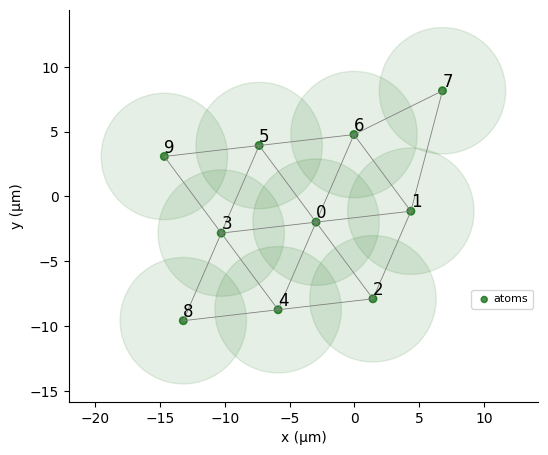

In [56]:
# create a register on NAQC
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(omega_max),
    draw_graph=True,
    draw_half_radius=True,
)

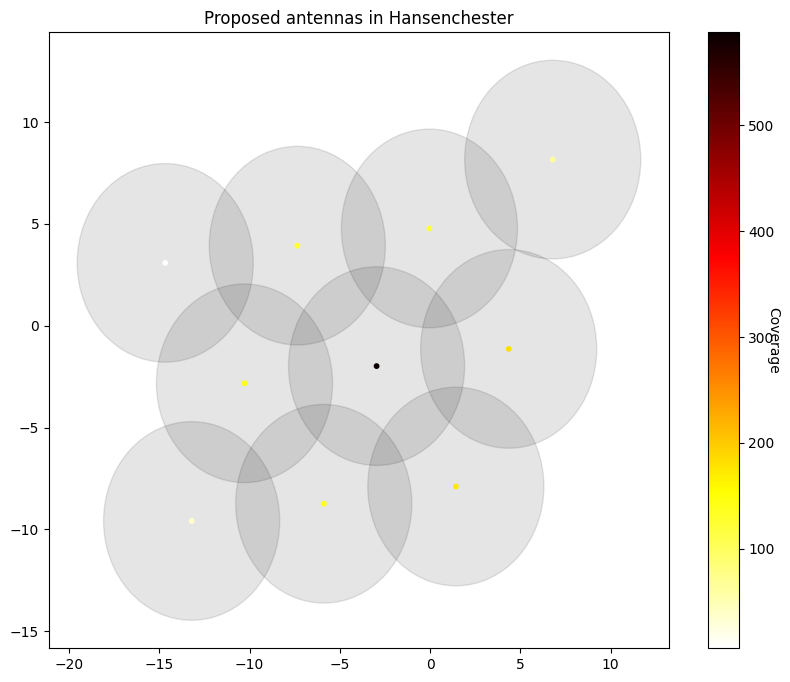

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.title('Proposed antennas in {}'.format(city_name))
ind = 0
for (xi, yi) in zip(np.array(coords)[:,0], np.array(coords)[:,1]):
    circle = patches.Circle((xi, yi), R_antennas, edgecolor='black', facecolor='black', transform=ax.transData, alpha = 0.1)
    ax.add_patch(circle)
    ind += 1
scatter = ax.scatter(np.array(coords)[:,0], np.array(coords)[:,1], s=10, c = z_coverage, cmap = 'hot_r')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Coverage', rotation=270)

{0: Text(-2.962853818422556, -1.9820647055225655, '0'),
 1: Text(4.3547116533016235, -1.1371050265400313, '1'),
 2: Text(1.427685464611952, -7.8967824584002955, '2'),
 4: Text(-5.889880007112227, -8.74174213738283, '4'),
 3: Text(-10.280419290146735, -2.827024384505098, '3'),
 8: Text(-13.207445478836407, -9.586701816365363, '8'),
 6: Text(-0.035827629732883885, 4.777612726337699, '6'),
 7: Text(6.79390014387635, 8.157451442267833, '7'),
 9: Text(-14.670958573181242, 3.0876933683726335, '9'),
 5: Text(-7.353393101457063, 3.932653047355165, '5')}

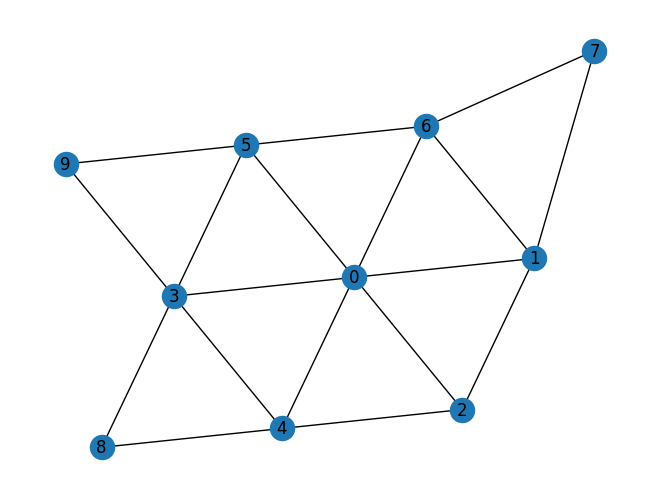

In [58]:
graph = nx.Graph()
edges = KDTree(coords).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)


In [59]:
def create_pulse(Omega_max, t_omega, detuning_values, detuning_times):
    # Create Pulse
    list_pulses = []
    # 1. rise to omega_max with 0 detuning
    rabi_t_rise, rabi_t_fall = t_omega
    list_pulses.append(Pulse.ConstantDetuning(
        amplitude=RampWaveform(rabi_t_rise, 0, Omega_max), 
        detuning=detuning_values[0], 
        phase=0)
        )
    # 2. Rampwaveforms from \Delta_{min} to \Delta_{max} with constant Omega_max
    counter = 0
    for i in range(time_interval_number):
        if i % 2 ==0:
            list_pulses.append(Pulse.ConstantAmplitude(
                amplitude=Omega_max, 
                detuning=RampWaveform(detuning_times[i], detuning_values[counter], detuning_values[counter+1]),
                phase=0
                ))
            counter += 1
        else:
            list_pulses.append(Pulse.ConstantAmplitude(
                amplitude=Omega_max, 
                detuning=ConstantWaveform(detuning_times[i], detuning_values[counter]),
                phase=0
                ))
    # 3. fall to 0 with \Delta_f detuning
    list_pulses.append(Pulse.ConstantDetuning(
        amplitude=RampWaveform(rabi_t_fall, Omega_max, 0), 
        detuning=detuning_values[-1], 
        phase=0)
        )
    return list_pulses
   

In [60]:
def create_sequence(omega_max, register, device_used, detunings_number, time_interval_number):
    # parametrized sequence
    parametrized_sequence = Sequence(register, device_used)
    parametrized_sequence.declare_channel("rydberg", "rydberg_global")
    # time to ramp to Maximum Rabi Frequency and time to ramp to 0
    t_omega = parametrized_sequence.declare_variable("t_omega", size=2, dtype=int)
    # detunings values
    detuning_values = parametrized_sequence.declare_variable("detuning_values", size=detunings_number, dtype=float)
    # detuning times intervals
    detuning_times = parametrized_sequence.declare_variable("detuning_times", size=time_interval_number, dtype=int)

    # Create Pulse
    list_pulses = create_pulse(omega_max, t_omega, detuning_values, detuning_times)

    # create sequence
    for i in range(len(list_pulses)):
        parametrized_sequence.add(list_pulses[i], "rydberg")
    return parametrized_sequence


In [61]:
# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Function to returns the size of the MIS
def mis_size(graph, bitstring):
    # Convert bitstring to list of node indices in the independent set
    node_set = convert_to_indices(bitstring)
    
    # Check if the node set is an independent set
    for node in node_set:
        for neighbor in graph.neighbors(node):
            if neighbor in node_set:
                return -4  # Return penalty if not an independent set
    
    # Return the size of the independent set if it passes the check
    return len(node_set)

# Function to calculate the weighted mean size of the MIS
def mean_mis_size(graph, solution_dict):
    total_weighted_size = 0
    total_counts = 0
    list_sizes = []

    for bitstring, count in solution_dict.items():
        list_sizes.append(mis_size(graph, bitstring))  # Get the size of the independent set or penalty
    
    max_size = max(list_sizes)
    updated_list_sizes = [size if size == max_size else 0 for size in list_sizes]  # Replace penalties with max size

    for size, count in zip(updated_list_sizes, solution_dict.values()):
        total_weighted_size += size * count
        total_counts += count

    mean_size = total_weighted_size / total_counts

    return mean_size

def get_cost_colouring(bitstring):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter):
    cost = sum(counter[key] * get_cost_colouring(key) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

In [62]:
def quantum_loop(param, omega_max, device_used, graph, reg, detunings_number):
    print(param)
    # retrieve the parameters
    Omega_max_param = omega_max
    t_omega_param = param[0:2]
    detuning_values_param = param[2:2+detunings_number]
    detuning_times_param = param[2+detunings_number:]
    
    # create the sequence
    parametrized_sequence = create_sequence(omega_max, reg, device_used, len(detuning_values_param), len(detuning_times_param))
    # build the sequence
    sequence = None
    try:
        sequence = parametrized_sequence.build(
            t_omega=t_omega_param,
            detuning_times = detuning_times_param, 
            detuning_values = detuning_values_param,
        )
    except:
        return 1000

    # simulation with Qutip emulator
    simulator = QutipEmulator.from_sequence(
        sequence, 
        sampling_rate=1,
        with_modulation = False,
        config=noise_config["noiseless"],
    )
    #simulator.show_config()
    results = simulator.run(progress_bar=False)
    count_dict = results.sample_final_state(N_samples=10000)
    # create an ordered dictionnary of the results
    #most_frequent = {k:v for k,v in count_dict.items() if v>10}
    #results_dictionnary = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
    # calculate the mean size of the MIS
    #mean_size = mean_mis_size(graph, results_dictionnary)
    mean_size = get_cost(count_dict)
    print(f'\n ---> Mean size  = {mean_size}')
    return mean_size


In [63]:
def optimization_loop(omega_max, device_used, graph, detunings_number, initial_guess, bounds, maxiter):
    res = minimize(
        quantum_loop,
        x0=initial_guess,
        args=(omega_max, device_used, graph, reg, detunings_number),
        bounds=bounds,
        method='Nelder-Mead',  
        options={"return_all": True, "maxiter": maxiter, "adaptive": True},
    )
    return res

In [64]:
# number of segment for the detuning
detunings_number = 5
# number of time intervals for the detuning
time_interval_number = 2*detunings_number - 3
# Initial guess for the parameters 
init_t_omega = np.array([250, 500])
init_detuning_values = np.linspace(delta_0, delta_f, detunings_number)
init_detuning_times = np.array([300]*time_interval_number)
# Flatten and concatenate all parameters into a one-dimensional array
initial_guess = init_t_omega.tolist() + init_detuning_values.tolist() + init_detuning_times.tolist()
# Maximum number of iterations
maxiter = 100
# Bounds for each parameter for the analog device (see: device_used.print_specs())
max_time_omega = (int)(4000/6)
max_time_detuning = (int)((4000-2*max_time_omega) / (time_interval_number))
print(2*max_time_omega + max_time_detuning*time_interval_number)
print(f'Max time for omega = {max_time_omega} and max time for detuning = {max_time_detuning}')
bounds = [(20, max_time_omega)]*2        # Bounds for t_omega_param (since t_omega + sum(detuning_times) <= 4000)
bounds += [(-40, 60)] * detunings_number  # Bounds for each element in detuning_values_param
bounds += [(20, max_time_detuning)] * time_interval_number    # Bounds for each element in detuning_times_param

3999
Max time for omega = 666 and max time for detuning = 381


In [66]:
res = optimization_loop(omega_max, device_used, graph, detunings_number, initial_guess, bounds, 1)

[250.         500.         -37.69911184 -25.13274123 -12.56637061
   0.          12.56637061 300.         300.         300.
 300.         300.         300.         300.        ]



 ---> Mean size  = 6.229709478033726
[262.5        500.         -37.69911184 -25.13274123 -12.56637061
   0.          12.56637061 300.         300.         300.
 300.         300.         300.         300.        ]

 ---> Mean size  = 6.383350120243613
[250.         525.         -37.69911184 -25.13274123 -12.56637061
   0.          12.56637061 300.         300.         300.
 300.         300.         300.         300.        ]

 ---> Mean size  = 6.148860266100836
[250.         500.         -39.58406744 -25.13274123 -12.56637061
   0.          12.56637061 300.         300.         300.
 300.         300.         300.         300.        ]

 ---> Mean size  = 6.219363694083325
[250.         500.         -37.69911184 -26.38937829 -12.56637061
   0.          12.56637061 300.         300.         300.
 300.         300.         300.         300.        ]

 ---> Mean size  = 6.2192296433102445
[250.         500.         -37.69911184 -25.13274123 -13.19468915
   0.          12.56637061 300.

t_omega =  [250. 525.]
detuning_times =  [300. 300. 300. 300. 300. 300. 300.]
detuning_values =  [-37.69911184 -25.13274123 -12.56637061   0.          12.56637061]


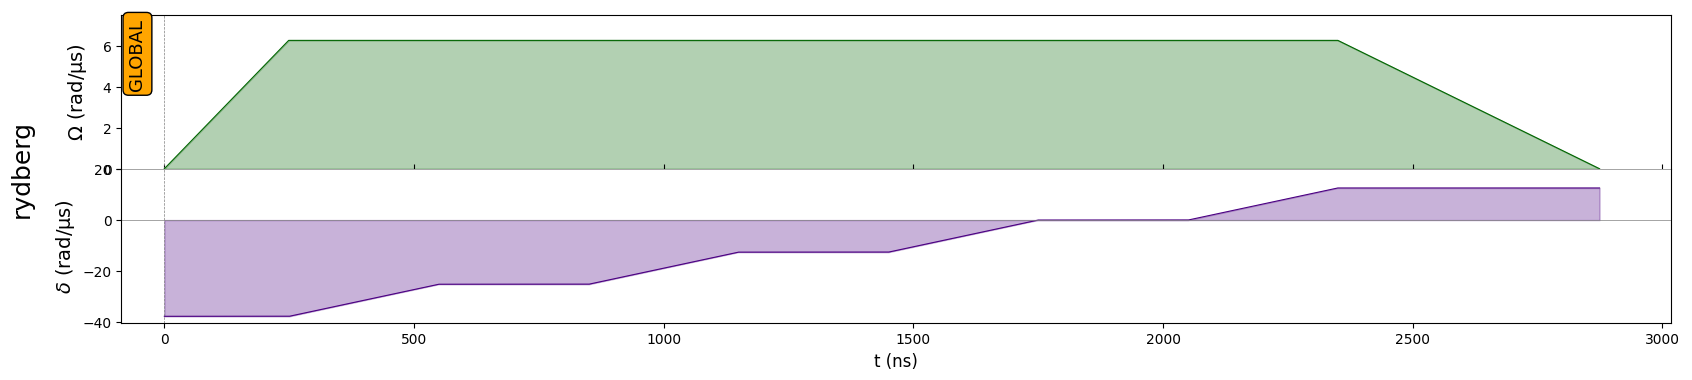

In [67]:
# retrieve the parameters
t_omega_param = res.x[0:2]
detuning_values_param = res.x[2:2+detunings_number]
detuning_times_param = res.x[2+detunings_number:]

print('t_omega = ', t_omega_param)
print('detuning_times = ', detuning_times_param)
print('detuning_values = ', detuning_values_param)

# create the sequence
parametrized_sequence = create_sequence(omega_max, reg, device_used, len(detuning_values_param), len(detuning_times_param))
# build the sequence
sequence = parametrized_sequence.build(
    t_omega=t_omega_param,
    detuning_times = detuning_times_param, 
    detuning_values = detuning_values_param,
)
sequence.draw()

In [68]:
simulator = QutipEmulator.from_sequence(
    sequence, 
    sampling_rate=1,
    with_modulation = False,
    config=noise_config["noiseless"],
)
simulator.show_config()
results = simulator.run(progress_bar=True)
count_dict = results.sample_final_state(N_samples=10000)

Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   0.75s. Est. time left: 00:00:00:06
20.0%. Run time:   1.12s. Est. time left: 00:00:00:04
30.0%. Run time:   1.42s. Est. time left: 00:00:00:03
40.0%. Run time:   1.70s. Est. time left: 00:00:00:02
50.0%. Run time:   1.98s. Est. time left: 00:00:00:01
60.0%. Run time:   2.73s. Est. time left: 00:00:00:01
70.0%. Run time:   3.41s. Est. time left: 00:00:00:01
80.0%. Run time:   3.81s. Est. time left: 00:00:00:00
90.0%. Run time:   4.59s. Est. time left: 00:00:00:00
Total run time:   5.19s


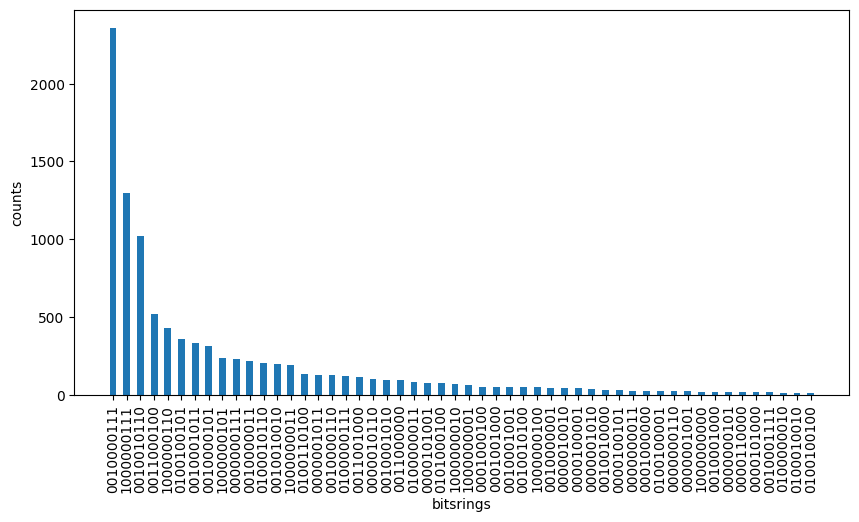

In [69]:
most_frequent = {k:v for k,v in count_dict.items() if v>10}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

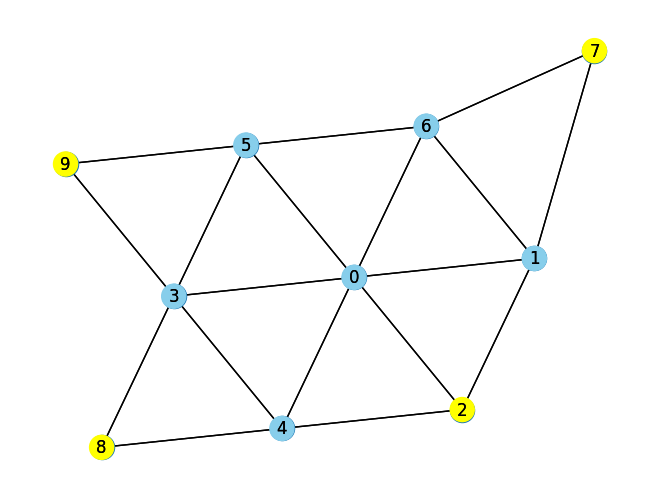

In [70]:
# Sort the bitstrings in descending order
solution = [key for key, value in sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)]


# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']



# Draw the graph with colored nodes
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

# Example graph drawing
highlighted_nodes = convert_to_indices(solution[0])

# Assign colors: 'yellow' for highlighted nodes, 'skyblue' for others
node_colors = ['yellow' if node in highlighted_nodes else 'skyblue' for node in graph.nodes()]

nx.draw(graph, pos=coords, node_color=node_colors, with_labels=True)

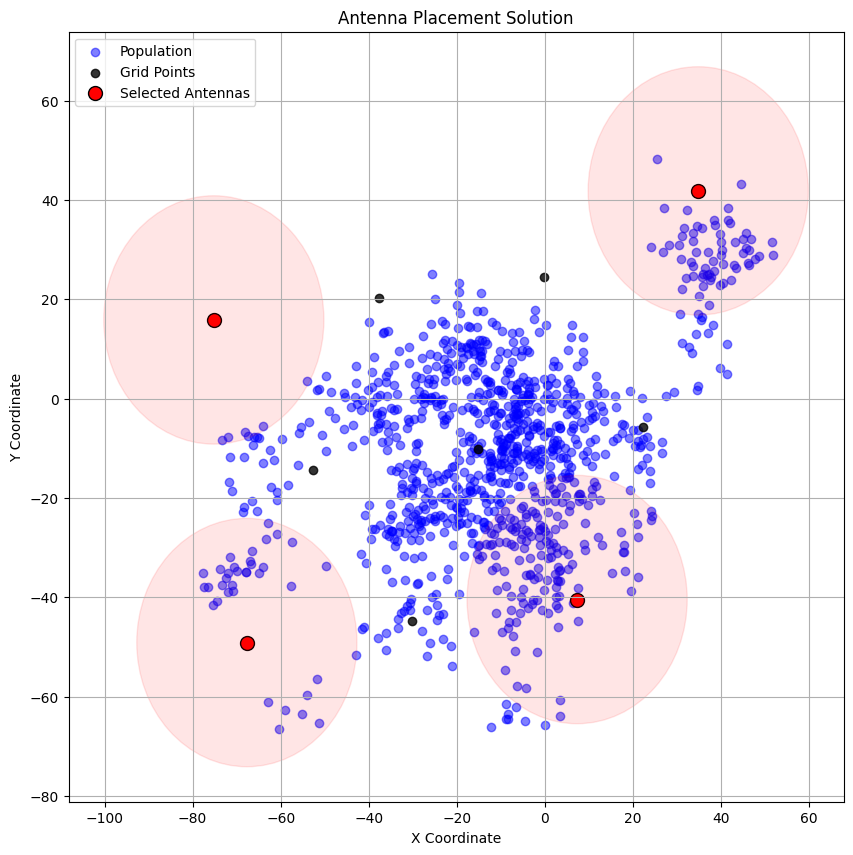

Population coverage: 277.0 out of 1000
Evaluation coverage: 277


In [71]:
# Plot the solution with selected antennas
plt.figure(figsize=(10, 10))

# Plot population points
plt.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)

# Plot all candidate grid points
plt.scatter(np.array(grid_points)[:,0], np.array(grid_points)[:, 1], c='black', label='Grid Points', alpha=0.8)

# Highlight the selected antennas
selected_antennas = highlighted_nodes
selected_antennas_positions = [grid_points[i] for i in selected_antennas]
selected_antennas_x = [pos[0] for pos in selected_antennas_positions]
selected_antennas_y = [pos[1] for pos in selected_antennas_positions]
plt.scatter(selected_antennas_x, selected_antennas_y, c='red', label='Selected Antennas', s=100, edgecolors='black')

# Plot coverage circles for selected antennas
real_R = 25
for pos in selected_antennas_positions:
    circle = plt.Circle((pos[0], pos[1]), real_R, color='red', alpha=0.1)
    plt.gca().add_patch(circle)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Antenna Placement Solution')
plt.legend()
plt.grid(True)
plt.show()

score = evaluate_coverage_final(population_x, population_y, selected_antennas_positions, real_R)
population_coverage = np.sum([z_coverage[i] for i in selected_antennas])
print(f'Population coverage: {population_coverage} out of {len(population_x)}')
print(f'Evaluation coverage: {score}')